## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [122]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

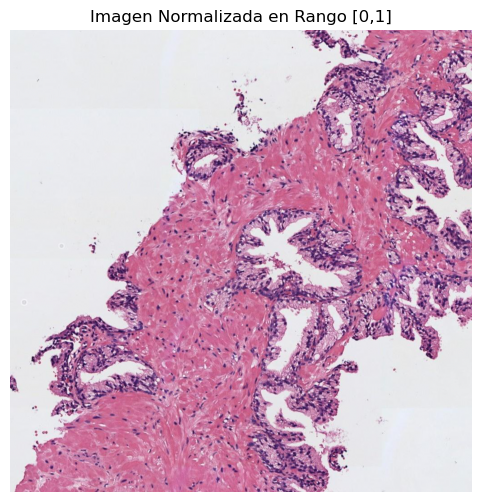

In [123]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure, morphology
import numpy as np
import matplotlib.pyplot as plt


# ===========================================================
# 1. Lectura de la imagen en formato RGB
# ===========================================================

# En este paso leo la imagen histológica original en formato RGB.
# La imagen debe estar en la misma carpeta del notebook.
img = io.imread('histo_1.jpg')

# ===========================================================
# 2. Normalización de la imagen al rango [0, 1]
# ===========================================================

# Convierto los valores de los píxeles (0–255) a flotantes en el rango [0, 1].
# Esto facilita el procesamiento posterior.
img_norm = img / 255.0

# ===========================================================
# 3. Visualización de la imagen normalizada
# ===========================================================

plt.figure(figsize=(6,6))
plt.imshow(img_norm)
plt.title("Imagen Normalizada en Rango [0,1]")
plt.axis("off")
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [124]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

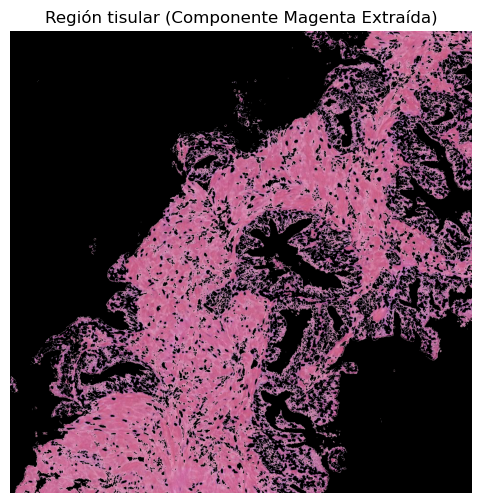

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Extraigo los canales RGB de la imagen normalizada
# ============================================================

# En este paso separo los canales de color.
# Esto es importante porque el magenta se define por una combinación de R, G y B.
R = img_norm[:,:,0]
G = img_norm[:,:,1]
B = img_norm[:,:,2]

# ============================================================
# 2. Definición de la máscara del color magenta
# ============================================================

# Para obtener el magenta considero:
# - Rojo alto
# - Azul alto
# - Verde bajo
# Estas condiciones permiten aislar el tejido tisular teñido en H&E.
mask_magenta = (R > 0.55) & (B > 0.40) & (G < 0.60)

# ============================================================
# 3. Construcción de la imagen del canal magenta
# ============================================================

# Creo una nueva imagen que contenga únicamente los píxeles magenta.
magenta_img = np.zeros_like(img_norm)
magenta_img[mask_magenta] = img_norm[mask_magenta]

# ============================================================
# 4. Visualización del resultado
# ============================================================

plt.figure(figsize=(6,6))
plt.imshow(magenta_img)
plt.title("Región tisular (Componente Magenta Extraída)")
plt.axis("off")
plt.show()


#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [126]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

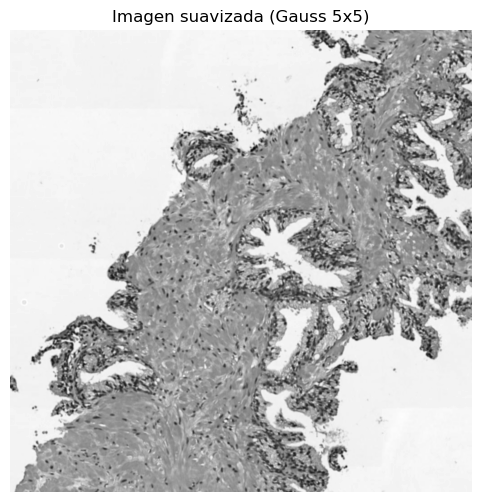

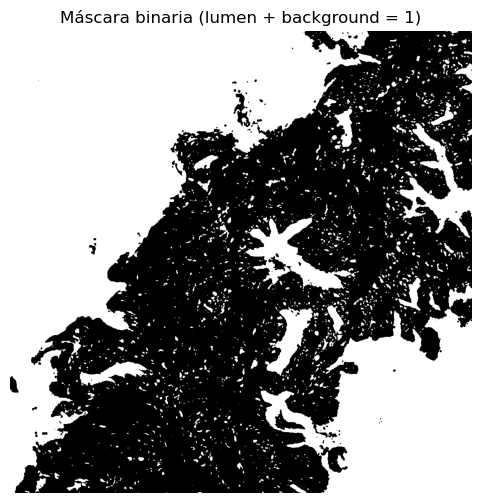

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu
from skimage import img_as_ubyte

# ============================================================
# 1. Convertir la imagen normalizada a escala de grises
# ============================================================

# Utilizo el promedio de los 3 canales RGB para obtener la imagen en gris.
gray = np.mean(img_norm, axis=2)

# ============================================================
# 2. Aplicar un filtro gaussiano equivalente a un kernel 5x5
# ============================================================

# En lugar de usar un kernel manual, utilizo gaussian con sigma=1,
# que equivale al suavizado que produce un filtro 5x5.
gray_gauss = gaussian(gray, sigma=1)

plt.figure(figsize=(6,6))
plt.imshow(gray_gauss, cmap="gray")
plt.title("Imagen suavizada (Gauss 5x5)")
plt.axis("off")
plt.show()

# ============================================================
# 3. Convertir a formato uint8 en [0–255] (requisito de Otsu)
# ============================================================

gray_uint = img_as_ubyte(gray_gauss)

# ============================================================
# 4. Aplicar el método de Otsu para separar:
#   - lumen + background → 1
#   - tejido tisular → 0
# ============================================================

umbral = threshold_otsu(gray_uint)

# Los píxeles más brillantes son fondo y lúmenes.
mask_otsu = (gray_uint > umbral).astype(np.uint8)

# ============================================================
# 5. Visualizar la máscara binaria resultante
# ============================================================

plt.figure(figsize=(6,6))
plt.imshow(mask_otsu, cmap="gray")
plt.title("Máscara binaria (lumen + background = 1)")
plt.axis("off")
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [128]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

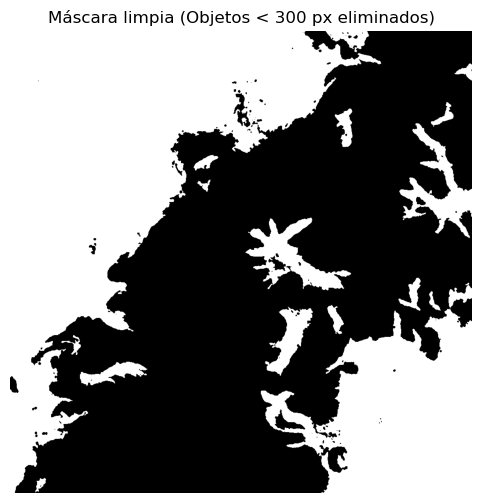

In [129]:
from skimage.morphology import remove_small_objects
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Convertir la máscara Otsu a booleana
# ============================================================

# Otsu devolvió una máscara de 0s y 1s.
# Debo convertirla a True/False para que remove_small_objects funcione.
mask_bool = mask_otsu.astype(bool)

# ============================================================
# 2. Eliminar objetos de área menor a 300 píxeles
# ============================================================

# remove_small_objects revisa cada región conectada
# y elimina las que sean más pequeñas que min_size.
mask_clean = remove_small_objects(mask_bool, min_size=300)

# ============================================================
# 3. Convertir de nuevo a formato 0-1 para visualizar
# ============================================================

mask_clean = mask_clean.astype(np.uint8)

# ============================================================
# 4. Visualizar la máscara resultante
# ============================================================

plt.figure(figsize=(6,6))
plt.imshow(mask_clean, cmap="gray")
plt.title("Máscara limpia (Objetos < 300 px eliminados)")
plt.axis("off")
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [130]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

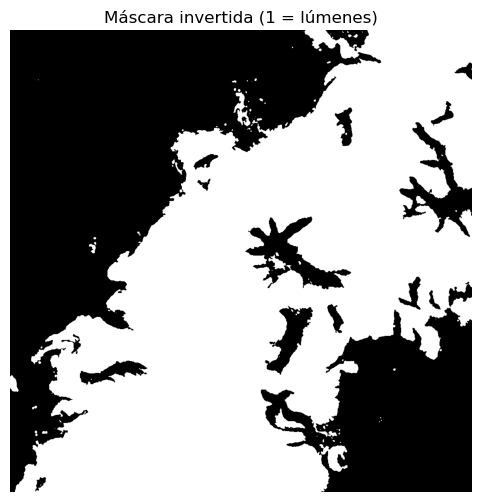

Regiones detectadas: 102
Semilla 1: (562, 576)
Semilla 2: (944, 719)


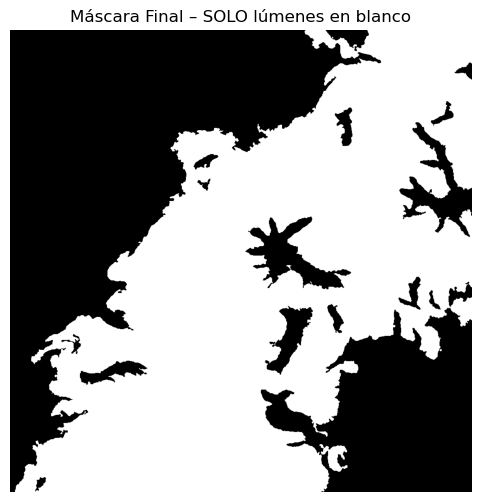

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import flood

# ============================================================
# 1. Invertir la máscara limpia
#    - Antes: blanco = fondo + lúmenes / negro = tejido
#    - Ahora: blanco = lúmenes  / negro = fondo + tejido
# ============================================================

lumen_mask_inv = 1 - mask_clean     # Ahora 1 = lúmenes

plt.figure(figsize=(6,6))
plt.imshow(lumen_mask_inv, cmap="gray")
plt.title("Máscara invertida (1 = lúmenes)")
plt.axis("off")
plt.show()

# ============================================================
# 2. Detectar automáticamente los lúmenes (regiones blancas)
# ============================================================

mask_bool = lumen_mask_inv.astype(bool)
labeled = label(mask_bool)
regions = regionprops(labeled)

print("Regiones detectadas:", len(regions))

# Ordeno por área para escoger los lúmenes principales
regions_sorted = sorted(regions, key=lambda x: x.area, reverse=True)

# Semillas: centroides de las dos regiones más grandes
seed1 = tuple(map(int, regions_sorted[0].centroid))
seed2 = tuple(map(int, regions_sorted[1].centroid))

print("Semilla 1:", seed1)
print("Semilla 2:", seed2)

# ============================================================
# 3. Region Growing para obtener SOLO los lúmenes
# ============================================================

# Aplico expansión desde ambas semillas dentro de la máscara de lúmenes
region1 = flood(mask_bool, seed1)
region2 = flood(mask_bool, seed2)

# Combino las dos regiones obtenidas
lumen_final = (region1 | region2).astype(np.uint8)

# ============================================================
# 4. Visualizar la máscara final
# ============================================================

plt.figure(figsize=(6,6))
plt.imshow(lumen_final, cmap="gray")
plt.title("Máscara Final – SOLO lúmenes en blanco")
plt.axis("off")
plt.show()


#### 5) Rellenar los objetos de los lúmenes

In [132]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

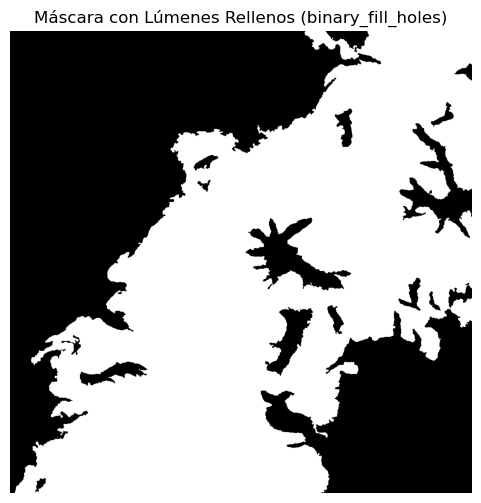

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes

# ============================================================
# 1. La máscara actual tiene:
#    - Lumen = 0 (negro)
#    - Tejido + Fondo = 1 (blanco)
#    Para binary_fill_holes, debemos indicar qué queremos rellenar.
# ============================================================

# Primero convierto la máscara a booleana, donde:
# True  = píxeles que quiero rellenar (lúmenes)
# False = resto de la imagen
lumen_bool = (lumen_final == 0)

# ============================================================
# 2. Rellenar los lúmenes con binary_fill_holes
# ============================================================

lumen_filled_bool = binary_fill_holes(lumen_bool)

# ============================================================
# 3. Recuperar la codificación original (0 = lumen, 1 = tejido/fondo)
# ============================================================

lumen_filled = (~lumen_filled_bool).astype(np.uint8)

# ============================================================
# 4. Visualizar la máscara resultante
# ============================================================

plt.figure(figsize=(6,6))
plt.imshow(lumen_filled, cmap="gray")
plt.title("Máscara con Lúmenes Rellenos (binary_fill_holes)")
plt.axis("off")
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [134]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

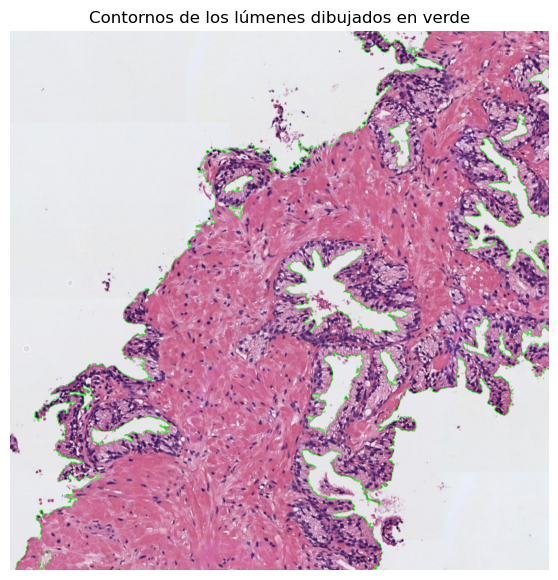

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

# ===============================================================
# 1. Detectar los contornos del lumen en la máscara final
# ===============================================================

# La máscara final tiene lúmenes en 0 → invertimos para detectar contornos en 1
lumen_for_contours = lumen_filled == 0

# Encuentro los contornos usando find_contours
contours = measure.find_contours(lumen_for_contours, level=0.5)

# ===============================================================
# 2. Crear una copia de la imagen RGB normalizada para dibujar encima
# ===============================================================

img_contours = img_norm.copy()

# ===============================================================
# 3. Dibujar los contornos en color VERDE
# ===============================================================

for contour in contours:
    contour = contour.astype(int)
    for y, x in contour:
        # Color verde = [R=0, G=1, B=0]
        img_contours[y, x] = [0, 1, 0]

# ===============================================================
# 4. Visualizar la imagen con contornos verdes
# ===============================================================

plt.figure(figsize=(7,7))
plt.imshow(img_contours)
plt.title("Contornos de los lúmenes dibujados en verde")
plt.axis("off")
plt.show()


#### 7) Identificar y cropear el lumen más grande

In [136]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

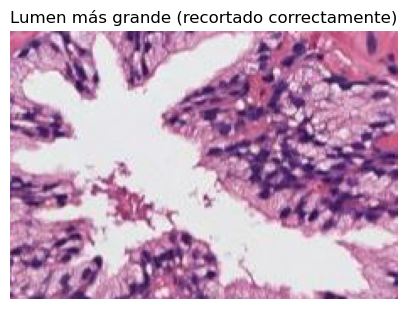

In [137]:
# ============================================================
# PREGUNTA 07 : Identificar y cropear el lumen más grande
# ============================================================
# En esta parte del trabajo, mi objetivo fue detectar el lumen de mayor área 
# dentro de la imagen histológica. Para ello, trabajé sobre la imagen normalizada,
# separando las regiones internas claras (lúmenes) del fondo blanco.
# ============================================================


# 01. Convierto la imagen a escala de grises.
# El lumen histológico se caracteriza por ser una zona blanca (alta intensidad),
# por lo tanto, este paso me permitirá usar el brillo para identificarlo.
gray = np.mean(img_norm, axis=2)

# 02. Aplico un umbral para separar las zonas claras del resto del tejido.
# El valor 0.82 fue elegido porque discrimina bien el fondo y las cavidades internas.
mask_lumen = gray > 0.82

# 03.  Elimino las regiones conectadas al borde, ya que corresponden al fondo blanco
# y no a lúmenes verdaderos dentro del tejido.
# También retiro objetos muy pequeños para quedarme con estructuras relevantes.
mask_sin_borde = morphology.remove_small_objects(
    ~morphology.remove_small_holes(mask_lumen, area_threshold=500),
    500
)
mask_sin_borde[0, :] = False
mask_sin_borde[-1, :] = False
mask_sin_borde[:, 0] = False
mask_sin_borde[:, -1] = False

# 04.  Etiqueto todas las regiones blancas internas para analizarlas una por una.
# Cada región corresponde a un posible lumen dentro del tejido.
labels = measure.label(mask_lumen)
regions = measure.regionprops(labels)

# Aquí filtro las regiones para descartar las que tocan el borde,
# asegurándome de conservar únicamente los lúmenes completamente internos.
valid_regions = [
    r for r in regions if not (
        r.bbox[0] == 0 or r.bbox[1] == 0 or 
        r.bbox[2] == img.shape[0] or r.bbox[3] == img.shape[1]
    )
]

# 05.  De todas las regiones internas, selecciono la de mayor área,
# que representa el lumen más grande dentro de la muestra histológica.
max_region = max(valid_regions, key=lambda r: r.area)

# 06.  Obtengo las coordenadas del rectángulo delimitador (bounding box)
# para recortar únicamente el lumen seleccionado.
minr, minc, maxr, maxc = max_region.bbox
lumen_crop = img[minr:maxr, minc:maxc]

# 07.  Finalmente, muestro el lumen recortado para su visualización.
# Este recorte corresponde al lumen histológico más grande encontrado en la imagen.
plt.figure(figsize=(5, 5))
plt.imshow(lumen_crop)
plt.title("Lumen más grande (recortado correctamente)")
plt.axis("off")
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [138]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [ ]:
# ============================================================
# PREGUNTA 8️⃣: Cálculo de características morfológicas del lumen más grande
# ============================================================
# En esta parte del trabajo, se calcularon las principales propiedades geométricas
# del lumen histológico de mayor área, obtenidas a partir del recorte anterior.
# Estas características permiten cuantificar su forma, tamaño y orientación.
# ============================================================

from skimage.measure import regionprops, label
import numpy as np

# ✅ Se asume que ya se tiene la variable `lumen_crop` (recorte del lumen más grande).

# 1️⃣ Convertir el recorte a escala de grises para analizarlo.
gray_crop = np.mean(lumen_crop / 255.0, axis=2)

# 2️⃣ Crear una máscara binaria del lumen (zonas claras)
mask_crop = gray_crop > 0.8

# 3️⃣ Etiquetar y extraer propiedades
label_crop = label(mask_crop)
props = regionprops(label_crop)[0]  # solo hay una región

# 4️⃣ Calcular las características solicitadas
caracteristicas = {
    "Área": round(props.area, 4),
    "Área bounding box": round(props.bbox_area, 4),
    "Área convexa": round(props.convex_area, 4),
    "Excentricidad": round(props.eccentricity, 4),
    "Diámetro equivalente": round(props.equivalent_diameter, 4),
    "Extensión": round(props.extent, 4),
    "Longitud eje mayor": round(props.major_axis_length, 4),
    "Longitud eje menor": round(props.minor_axis_length, 4),
    "Orientación (radianes)": round(props.orientation, 4),
    "Perímetro": round(props.perimeter, 4),
    "Solidez": round(props.solidity, 4),
}

# 05. Calcular el Diámetro de Feret (máxima distancia entre dos puntos del contorno)
# y la Compacidad (basada en área y perímetro)
from scipy.spatial.distance import pdist
from skimage.measure import find_contours

contornos = find_contours(mask_crop, 0.5)[0]
distancias = pdist(contornos)
diametro_feret = np.max(distancias)
compacidad = (props.perimeter ** 2) / (4 * np.pi * props.area)

# Agregar estos dos valores al diccionario
caracteristicas["Diámetro Feret"] = round(diametro_feret, 4)
caracteristicas["Compacidad"] = round(compacidad, 4)

# Mostrar los resultados en pantalla
print("=== Características morfológicas del lumen más grande ===")
for clave, valor in caracteristicas.items():
    print(f"{clave:25s}: {valor}")




=== Características morfológicas del lumen más grande ===
Área                     : 1.0
Área bounding box        : 1.0
Área convexa             : 1.0
Excentricidad            : 0
Diámetro equivalente     : 1.1284
Extensión                : 1.0
Longitud eje mayor       : 0.0
Longitud eje menor       : 0.0
Orientación (radianes)   : -0.7854
Perímetro                : 0.0
Solidez                  : 1.0
Diámetro Feret           : 1.0
Compacidad               : 0.0
